In [2]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from pyarrow import feather
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import sem
from scipy.stats import entropy


plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (10, 10)

In [5]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [6]:
os.getcwd()

'C:\\Users\\Bio_Psych\\Desktop\\Deniz\\tf-cpu\\p1_generalization'

In [4]:
rel_rew_arr = []
acc_arr = []
n_bins = 10

### lSTM

for id_ in range(20):
    for walk in range(1,4):
        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()
        df = d.reset_index()


        best_reward = np.array(np.max(df[['p_rew_1', 'p_rew_2', 'p_rew_3', 'p_rew_4']], axis = 1))
        rel_reward = [best_reward[t] -  np.mean(np.array([p1, p2, p3, p4])[[[p1,p2,p3,p4]!=best_reward[t]]]) for t, p1, p2, p3, p4 in zip(range(len(best_reward)), df['p_rew_1'], df['p_rew_2'], df['p_rew_3'], df['p_rew_4'])]
        
        rel_reward = np.multiply(rel_reward,100)
        
        rel_rew_arr.extend(rel_reward)
        acc_arr.extend(df['accuracy'].values)

### Human        

path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

rel_rew_arr_hum = []
acc_arr_hum = []

for sub in range(1, 32):
        df = human_df[human_df['vp'].values==sub]
        
        best_reward = np.array(np.max(df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']], axis = 1))
        
        accuracy = [int((ch-1)==np.argmax([p1,p2,p3,p4])) for ch, p1, p2, p3, p4 in zip(df['choice'], df['reward_b1'], df['reward_b2'], df['reward_b3'], df['reward_b4'])]
        
        rel_reward = [best_reward[t] -  np.mean(np.array([p1, p2, p3, p4])[[[p1,p2,p3,p4]!=best_reward[t]]]) for t, p1, p2, p3, p4 in zip(range(len(best_reward)), df['reward_b1'], df['reward_b2'], df['reward_b3'], df['reward_b4'])]

        rel_rew_arr_hum.extend(rel_reward)
        acc_arr_hum.extend(accuracy)
        



C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [5]:
# create df
df = pd.DataFrame({'rel_rew': rel_rew_arr + rel_rew_arr_hum, 'acc': acc_arr + acc_arr_hum, 'type': ['lstm'] * len(rel_rew_arr) + ['human'] * len(rel_rew_arr_hum)})

# create bins
df['rel_rew_bins'] = pd.qcut(df['rel_rew'], q=n_bins)

print('human bin counts')
print(df[df['type'] == 'human'].value_counts('rel_rew_bins'))

print('lstm bin counts')
print(df[df['type'] == 'lstm'].value_counts('rel_rew_bins'))


plot_df = df.groupby(['rel_rew_bins', 'type']).mean().reset_index()

human bin counts
rel_rew_bins
(2.612, 9.58]       954
(18.084, 20.291]    941
(12.739, 15.102]    933
(29.943, 37.945]    930
(25.984, 29.943]    930
(37.945, 52.819]    926
(22.672, 25.984]    924
(20.291, 22.672]    921
(9.58, 12.739]      921
(15.102, 18.084]    920
dtype: int64
lstm bin counts
rel_rew_bins
(9.58, 12.739]      1820
(37.945, 52.819]    1800
(29.943, 37.945]    1800
(25.984, 29.943]    1800
(22.672, 25.984]    1800
(20.291, 22.672]    1800
(18.084, 20.291]    1800
(15.102, 18.084]    1800
(12.739, 15.102]    1800
(2.612, 9.58]       1780
dtype: int64


# logistic regression/psychometric curves

In [6]:
log_reg = sm.Logit(df[df['type'] == 'lstm']['acc'].values, df[df['type'] == 'lstm']['rel_rew'].values).fit()
print('lstm')
print(log_reg.summary())

x_rel_rew = np.linspace(0, 50, 1000)
y_lstm = log_reg.predict(x_rel_rew )

print('human')
log_reg = sm.Logit(df[df['type'] == 'human']['acc'].values, df[df['type'] == 'human']['rel_rew'].values).fit()
print(log_reg.summary())

y_human = log_reg.predict(x_rel_rew )

Optimization terminated successfully.
         Current function value: 0.650980
         Iterations 4
lstm
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                18000
Model:                          Logit   Df Residuals:                    17999
Method:                           MLE   Df Model:                            0
Date:                Mon, 29 Aug 2022   Pseudo R-squ.:                 0.03066
Time:                        10:37:13   Log-Likelihood:                -11718.
converged:                       True   LL-Null:                       -12088.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0252      0.001     37.493      0.000       0.024       0.026
human
Optimization termi

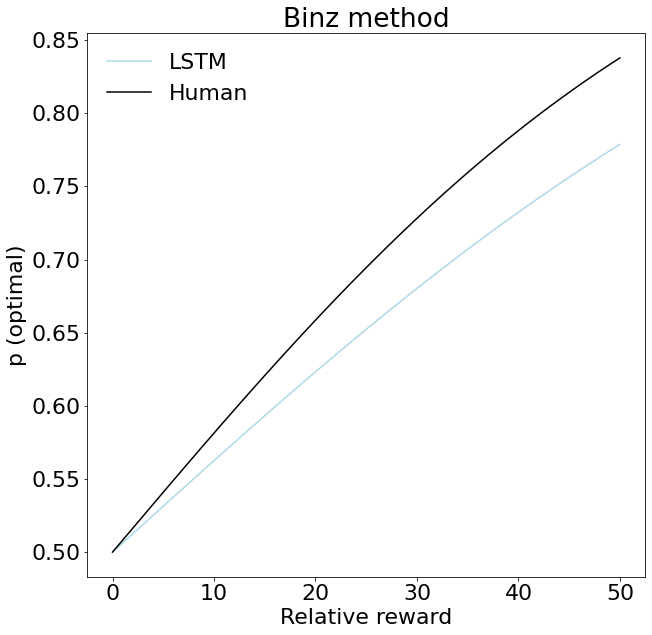

In [7]:
plt.plot(x_rel_rew, y_lstm, color='lightblue', label = 'LSTM')
plt.plot(x_rel_rew, y_human, color='black', label = 'Human')
plt.ylabel('p (optimal)')
plt.xlabel('Relative reward')
plt.title('Binz method')
plt.legend(frameon=False)

Text(0.5, 0, 'Relative reward')

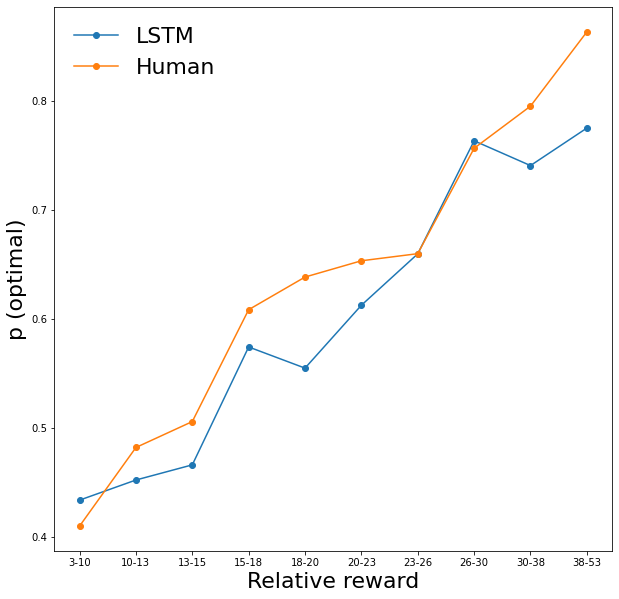

In [8]:
rr_bins = np.unique(plot_df['rel_rew_bins'])

my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 


plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.plot(range(len(plot_df[plot_df['type']=='lstm']['acc'])), plot_df[plot_df['type']=='lstm']['acc'], '-o', label = 'LSTM')

plt.plot(range(len(plot_df[plot_df['type']=='human']['acc'])), plot_df[plot_df['type']=='human']['acc'], '-o', label = 'Human')

plt.xticks(range(10), my_ticks)

plt.legend(frameon = False)

plt.ylabel('p (optimal)')
plt.xlabel('Relative reward')

# Uncertainty

In [9]:
# calculate uncertainty for options

def get_uncertainty(index, unc_vec):
    
    trials = np.arange(0,300,1)
    trials[index] = 0

    for t, unc in enumerate(unc_vec):

        if t ==0:
            trials[:index[t]] = np.arange(1,index[t]+1, 1)

        else: 
            trials[index[t-1]+1:index[t]] = np.arange(1,unc+1, 1)
            
        if t == len(unc_vec)-1 and index[t] < len(trials)-1:
            
#             pdb.set_trace()
            
            trials[index[t]+1:] = np.arange(1,(len(trials)-index[t]), 1)
            
    return(trials)



In [51]:
# for stay/switch predictions
lagged_unc_arr = []
switch_arr = []

# for action specific predictions
actions_1 = []
actions_2 = []
actions_3 = []
actions_4 = []

switch_lagged_unc_1_arr = []
switch_lagged_unc_2_arr = []
switch_lagged_unc_3_arr = []
switch_lagged_unc_4_arr = []

switched_lagged_unc_over_all_actions_arr = []

### lSTM

for id_ in range(20):
    for walk in range(1,4):
        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()
        
        one_index = np.where(df_lstm['choice'].values == 0)[0]
        unc_one = one_index - (pd.Series(one_index).shift(1).values +1)

        two_index = np.where(df_lstm['choice'].values == 1)[0]
        unc_two = two_index - (pd.Series(two_index).shift(1).values +1)

        three_index = np.where(df_lstm['choice'].values == 2)[0]
        unc_three = three_index - (pd.Series(three_index).shift(1).values +1)

        four_index = np.where(df_lstm['choice'].values == 3)[0]
        unc_four = four_index - (pd.Series(four_index).shift(1).values +1)

        # function call
        unc_1 = get_uncertainty(one_index, unc_one)
        unc_2 = get_uncertainty(two_index, unc_two)
        unc_3 = get_uncertainty(three_index, unc_three)
        unc_4 = get_uncertainty(four_index, unc_four)
        
        # subset uncertainty prior to choice
        lagged_unc_1 = pd.Series(unc_1).shift(1).values
        lagged_unc_2 = pd.Series(unc_2).shift(1).values
        lagged_unc_3 = pd.Series(unc_3).shift(1).values
        lagged_unc_4 = pd.Series(unc_4).shift(1).values
        
        # get all switches
        switch_df = df_lstm[df_lstm['is_switch']==1]

        # get binary variable for action a
        action_1 = switch_df['choice']==0
        action_2 = switch_df['choice']==1
        action_3 = switch_df['choice']==2
        action_4 = switch_df['choice']==3

        # get lagged relative uncertainty for action a
        switch_lagged_unc_1 = lagged_unc_1[np.array(switch_df.index)]
        switch_lagged_unc_2 = lagged_unc_2[np.array(switch_df.index)]
        switch_lagged_unc_3 = lagged_unc_3[np.array(switch_df.index)]
        switch_lagged_unc_4 = lagged_unc_4[np.array(switch_df.index)]

        lagged_ch_unc = [[u_1,u_2,u_3,u_4][ch] -  np.mean([u_1,u_2,u_3,u_4]) for ch, u_1,u_2,u_3,u_4 in zip(df_lstm['choice'], lagged_unc_1, lagged_unc_2, lagged_unc_3,lagged_unc_4)]
        
        
        # get uncertainty for actions corresponding to switch trials
        switched_lagged_unc_over_all_actions = [[u_1,u_2,u_3,u_4][ch] for ch, u_1,u_2,u_3,u_4 in zip(switch_df['choice'], switch_lagged_unc_1, switch_lagged_unc_2, switch_lagged_unc_3,switch_lagged_unc_4)]
        
        # add to result lists
        switched_lagged_unc_over_all_actions_arr.extend(switched_lagged_unc_over_all_actions)
        
        lagged_unc_arr.extend(lagged_ch_unc)
        switch_arr.extend(df_lstm['is_switch'].values)
        
        actions_1.extend(action_1)
        actions_2.extend(action_2)
        actions_3.extend(action_3)
        actions_4.extend(action_4)
        
        switch_lagged_unc_1_arr.extend(switch_lagged_unc_1)
        switch_lagged_unc_2_arr.extend(switch_lagged_unc_2)
        switch_lagged_unc_3_arr.extend(switch_lagged_unc_3)
        switch_lagged_unc_4_arr.extend(switch_lagged_unc_4)

prop_switches_LSTM = pd.Series(switched_lagged_unc_over_all_actions_arr).value_counts(normalize=True, sort= True)

In [52]:
############################################
# calculate uncertainty for human subjects #
############################################

# for stay/switch predictions
lagged_unc_arr_h = []
switch_arr_h = []

# for action specific predictions
actions_1_h = []
actions_2_h = []
actions_3_h = []
actions_4_h = []

switch_lagged_unc_1_arr_h = []
switch_lagged_unc_2_arr_h = []
switch_lagged_unc_3_arr_h = []
switch_lagged_unc_4_arr_h = []

switched_lagged_unc_over_all_actions_arr = []


path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

rel_rew_arr_hum = []
acc_arr_hum = []

for sub in range(1, 32):
    
    df_lstm = human_df[human_df['vp'].values==sub]
    df_lstm['choice'] = df_lstm['choice'].values-1

    one_index = np.where(df_lstm['choice'].values == 0)[0]
    unc_one = one_index - (pd.Series(one_index).shift(1).values +1)

    two_index = np.where(df_lstm['choice'].values == 1)[0]
    unc_two = two_index - (pd.Series(two_index).shift(1).values +1)

    three_index = np.where(df_lstm['choice'].values == 2)[0]
    unc_three = three_index - (pd.Series(three_index).shift(1).values +1)

    four_index = np.where(df_lstm['choice'].values == 3)[0]
    unc_four = four_index - (pd.Series(four_index).shift(1).values +1)

    # function call
    unc_1 = get_uncertainty(one_index, unc_one)
    unc_2 = get_uncertainty(two_index, unc_two)
    unc_3 = get_uncertainty(three_index, unc_three)
    unc_4 = get_uncertainty(four_index, unc_four)

    # subset uncertainty prior to choice
    lagged_unc_1 = pd.Series(unc_1).shift(1).values
    lagged_unc_2 = pd.Series(unc_2).shift(1).values
    lagged_unc_3 = pd.Series(unc_3).shift(1).values
    lagged_unc_4 = pd.Series(unc_4).shift(1).values

    # get all switches
    is_switch = [int(df_lstm['choice'].values[t] != df_lstm['choice'].values[t-1]) for t in range(1, len(df_lstm.choice))]
    is_switch = np.insert(is_switch, 0, 0) # insert leading 0, first element can't be switch
    df_lstm['is_switch'] = is_switch 
    switch_df = df_lstm[df_lstm['is_switch']==1]
    switch_df = switch_df.reset_index()

    # get binary variable for action a
    action_1 = switch_df['choice']==0
    action_2 = switch_df['choice']==1
    action_3 = switch_df['choice']==2
    action_4 = switch_df['choice']==3

    # get lagged relative uncertainty for action a
    switch_lagged_unc_1 = lagged_unc_1[np.array(switch_df.index)]
    switch_lagged_unc_2 = lagged_unc_2[np.array(switch_df.index)]
    switch_lagged_unc_3 = lagged_unc_3[np.array(switch_df.index)]
    switch_lagged_unc_4 = lagged_unc_4[np.array(switch_df.index)]


    lagged_ch_unc = [[u_1,u_2,u_3,u_4][ch] -  np.mean([u_1,u_2,u_3,u_4]) for ch, u_1,u_2,u_3,u_4 in zip(df_lstm['choice'], lagged_unc_1, lagged_unc_2, lagged_unc_3,lagged_unc_4)]

    # get uncertainty for actions corresponding to switch trials
    switched_lagged_unc_over_all_actions = [[u_1,u_2,u_3,u_4][ch] for ch, u_1,u_2,u_3,u_4 in zip(switch_df['choice'], switch_lagged_unc_1, switch_lagged_unc_2, switch_lagged_unc_3,switch_lagged_unc_4)]
        
    
    # add to result lists
    switched_lagged_unc_over_all_actions_arr.extend(switched_lagged_unc_over_all_actions)
    
    lagged_unc_arr.extend(lagged_ch_unc)
    switch_arr.extend(df_lstm['is_switch'].values)

    actions_1.extend(action_1)
    actions_2.extend(action_2)
    actions_3.extend(action_3)
    actions_4.extend(action_4)

    switch_lagged_unc_1_arr.extend(switch_lagged_unc_1)
    switch_lagged_unc_2_arr.extend(switch_lagged_unc_2)
    switch_lagged_unc_3_arr.extend(switch_lagged_unc_3)
    switch_lagged_unc_4_arr.extend(switch_lagged_unc_4)

 
prop_switches_human = pd.Series(switched_lagged_unc_over_all_actions_arr).value_counts(normalize=True, sort= True)

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

([<matplotlib.axis.XTick at 0x21efc9ff748>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

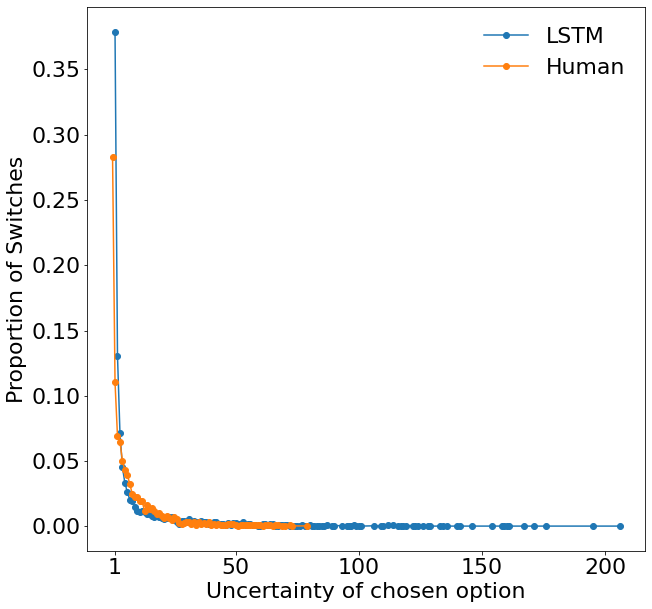

In [60]:
# plot p(switch) by uncertainty

plt.plot(prop_switches_LSTM.sort_index(), '-o', label = 'LSTM')
plt.plot(prop_switches_human.sort_index(), '-o', label = 'Human')
plt.legend(frameon = False)
plt.ylabel("Proportion of Switches")
plt.xlabel("Uncertainty of chosen option")
plt.xticks([1,50,100,150,200])


([<matplotlib.axis.XTick at 0x21e8101c4e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

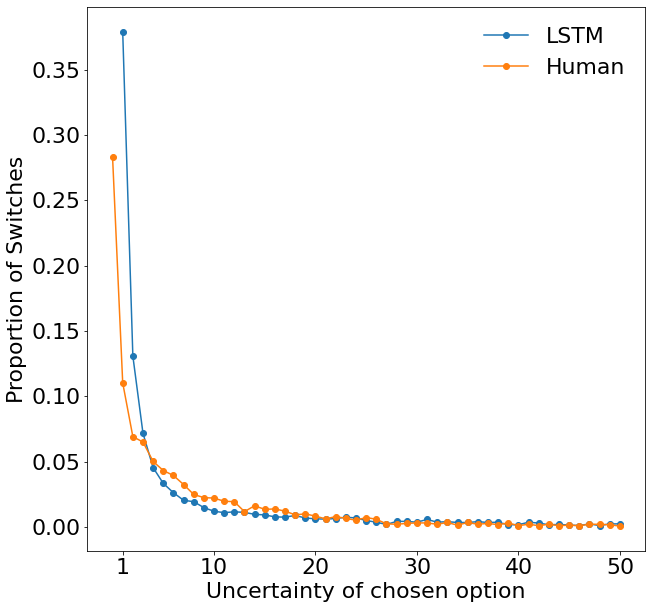

In [63]:
# plt.plot(prop_switches[:50], '-o', label = 'LSTM')
# plt.plot(prop_switches1[:50], '-o', label = 'Human')
# plt.legend(frameon = False)

plt.plot(prop_switches_LSTM.sort_index()[:50], '-o', label = 'LSTM')
plt.plot(prop_switches_human.sort_index()[:50], '-o', label = 'Human')
plt.legend(frameon = False)
plt.ylabel("Proportion of Switches")
plt.xlabel("Uncertainty of chosen option")
plt.xticks([1,10,20,30,40,50])

Text(0, 0.5, '% switch')

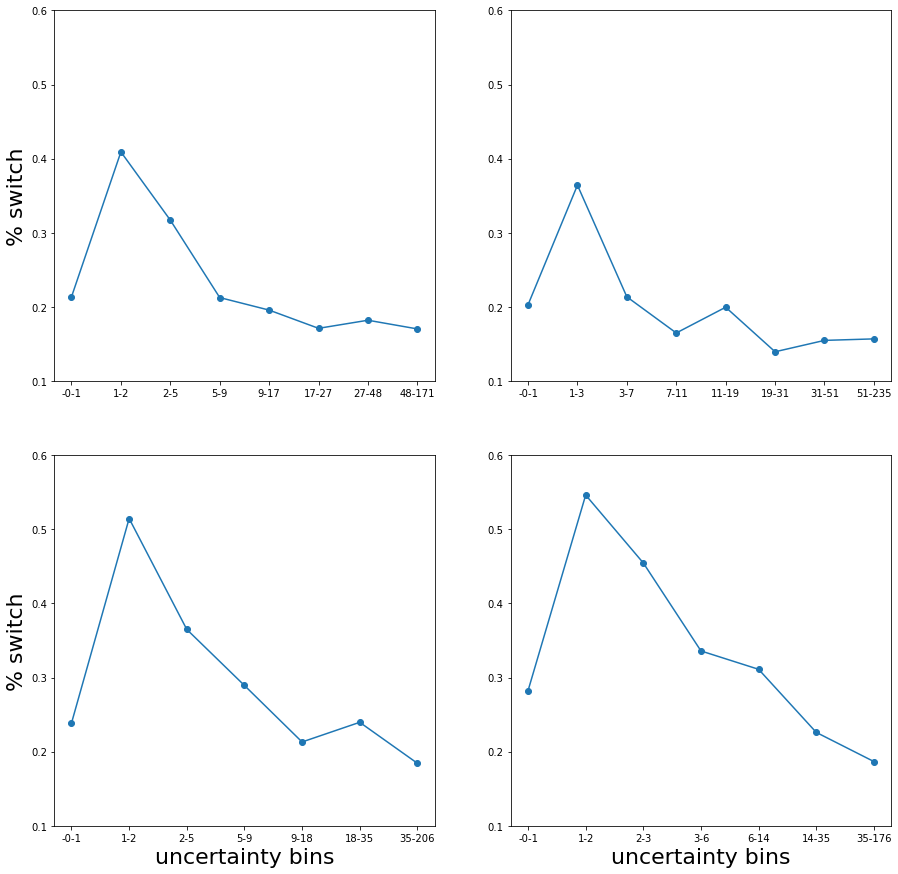

In [10]:
unc_df = pd.DataFrame({'actions_1': actions_1, 'actions_2': actions_2, 'actions_3': actions_3, 'actions_4': actions_4,
                      'lagged_unc_1': switch_lagged_unc_1_arr, 'lagged_unc_2': switch_lagged_unc_2_arr, 'lagged_unc_3': switch_lagged_unc_3_arr, 'lagged_unc_4': switch_lagged_unc_4_arr})

unc_df['lagged_unc_1_bins'] = pd.qcut(unc_df['lagged_unc_1'], q=10, duplicates = 'drop')
unc_df['lagged_unc_2_bins'] = pd.qcut(unc_df['lagged_unc_2'], q=10, duplicates = 'drop')
unc_df['lagged_unc_3_bins'] = pd.qcut(unc_df['lagged_unc_3'], q=10, duplicates = 'drop')
unc_df['lagged_unc_4_bins'] = pd.qcut(unc_df['lagged_unc_4'], q=10, duplicates = 'drop')



fig, ax = plt.subplots( 2,2)

fig.set_figheight(15)
fig.set_figwidth(15)



unc_plot_df = unc_df.groupby(['lagged_unc_1_bins']).mean()['actions_1']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,0].set_ylim([0.1, 0.6])
ax[0,0].set_xticks(range(8), my_ticks)
ax[0,0].tick_params(axis='both', which='major', labelsize=10)
ax[0,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_2_bins']).mean()['actions_2']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,1].set_ylim([0.1, 0.6])
ax[0,1].set_xticks(range(8), my_ticks)
ax[0,1].tick_params(axis='both', which='major', labelsize=10)
ax[0,1].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_3_bins']).mean()['actions_3']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[1,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,0].set_ylim([0.1, 0.6])
ax[1,0].set_xticks(range(7), my_ticks)
ax[1,0].tick_params(axis='both', which='major', labelsize=10)
ax[1,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_4_bins']).mean()['actions_4']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 


ax[1,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,1].set_ylim([0.1, 0.6])
ax[1,1].set_xticks(range(7), my_ticks)
ax[1,1].tick_params(axis='both', which='major', labelsize=10)
ax[1,1].tick_params(axis='both', which='minor', labelsize=8)

# labels

ax[1,1].set_xlabel('uncertainty bins')
ax[1,0].set_xlabel('uncertainty bins')

ax[0,0].set_ylabel('% switch')
ax[1,0].set_ylabel('% switch')

In [16]:
unc_df

,actions_1,actions_2,actions_3,actions_4,lagged_unc_1,lagged_unc_2,lagged_unc_3,lagged_unc_4,lagged_unc_1_bins,lagged_unc_2_bins,lagged_unc_3_bins,lagged_unc_4_bins
0,False,False,False,True,1.0,0.0,1.0,1.0,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]"
1,False,True,False,False,2.0,1.0,2.0,0.0,"(1.0, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]"
2,False,False,True,False,3.0,0.0,3.0,1.0,"(2.0, 5.0]","(-0.001, 1.0]","(2.0, 5.0]","(-0.001, 1.0]"
3,False,False,False,True,4.0,1.0,0.0,2.0,"(2.0, 5.0]","(-0.001, 1.0]","(-0.001, 1.0]","(1.0, 2.0]"
4,False,False,True,False,6.0,3.0,2.0,0.0,"(5.0, 9.0]","(1.0, 3.0]","(1.0, 2.0]","(-0.001, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
4644,False,False,False,True,123.0,0.0,7.0,1.0,"(48.0, 171.0]","(-0.001, 1.0]","(5.0, 9.0]","(-0.001, 1.0]"
4645,True,False,False,False,161.0,38.0,45.0,0.0,"(48.0, 171.0]","(31.0, 51.0]","(35.0, 206.0]","(-0.001, 1.0]"
4646,False,False,False,True,0.0,42.0,49.0,4.0,"(-0.001, 1.0]","(31.0, 51.0]","(35.0, 206.0]","(3.0, 6.0]"
4647,False,False,True,False,1.0,43.0,50.0,0.0,"(-0.001, 1.0]","(31.0, 51.0]","(35.0, 206.0]","(-0.001, 1.0]"


Text(0, 0.5, '% switch')

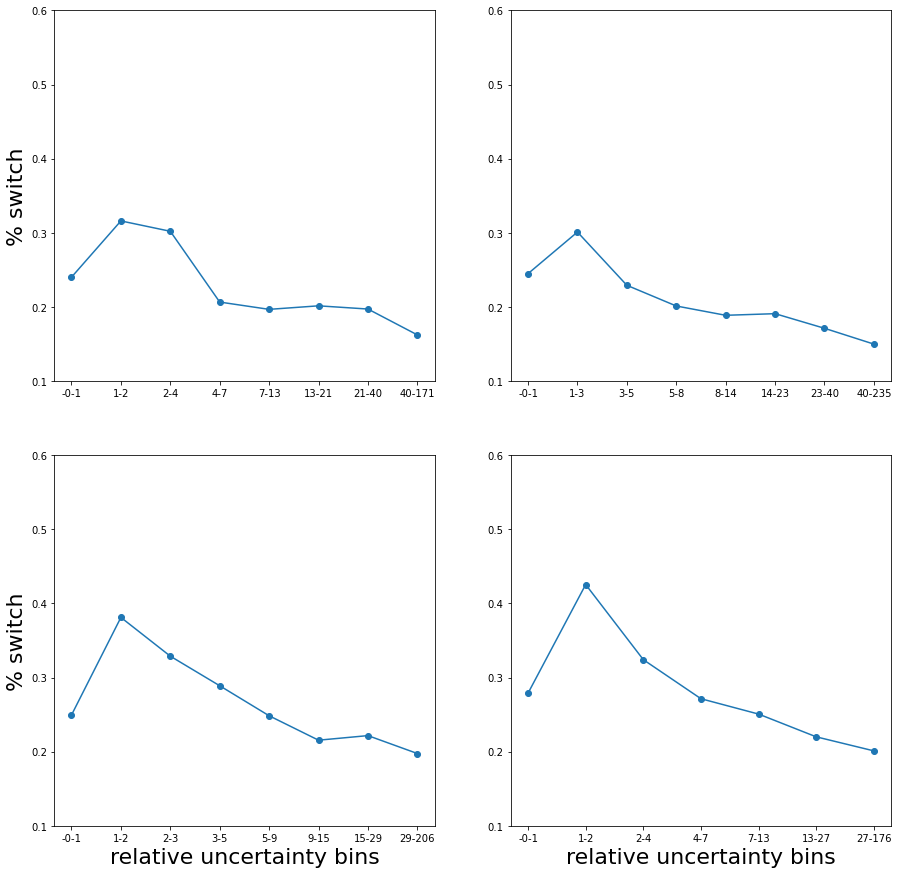

In [36]:
unc_df = pd.DataFrame({'actions_1': actions_1, 'actions_2': actions_2, 'actions_3': actions_3, 'actions_4': actions_4,
                      'lagged_unc_1': switch_lagged_unc_1_arr, 'lagged_unc_2': switch_lagged_unc_2_arr, 'lagged_unc_3': switch_lagged_unc_3_arr, 'lagged_unc_4': switch_lagged_unc_4_arr})

unc_df['lagged_unc_1_bins'] = pd.qcut(unc_df['lagged_unc_1'], q=10, duplicates = 'drop')
unc_df['lagged_unc_2_bins'] = pd.qcut(unc_df['lagged_unc_2'], q=10, duplicates = 'drop')
unc_df['lagged_unc_3_bins'] = pd.qcut(unc_df['lagged_unc_3'], q=10, duplicates = 'drop')
unc_df['lagged_unc_4_bins'] = pd.qcut(unc_df['lagged_unc_4'], q=10, duplicates = 'drop')



fig, ax = plt.subplots( 2,2)

fig.set_figheight(15)
fig.set_figwidth(15)



unc_plot_df = unc_df.groupby(['lagged_unc_1_bins']).mean()['actions_1']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,0].set_ylim([0.1, 0.6])
ax[0,0].set_xticks(range(8), my_ticks)
ax[0,0].tick_params(axis='both', which='major', labelsize=10)
ax[0,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_2_bins']).mean()['actions_2']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,1].set_ylim([0.1, 0.6])
ax[0,1].set_xticks(range(8), my_ticks)
ax[0,1].tick_params(axis='both', which='major', labelsize=10)
ax[0,1].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_3_bins']).mean()['actions_3']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[1,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,0].set_ylim([0.1, 0.6])
ax[1,0].set_xticks(range(8), my_ticks)
ax[1,0].tick_params(axis='both', which='major', labelsize=10)
ax[1,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_4_bins']).mean()['actions_4']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 


ax[1,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,1].set_ylim([0.1, 0.6])
ax[1,1].set_xticks(range(7), my_ticks)
ax[1,1].tick_params(axis='both', which='major', labelsize=10)
ax[1,1].tick_params(axis='both', which='minor', labelsize=8)

# labels

ax[1,1].set_xlabel('relative uncertainty bins')
ax[1,0].set_xlabel('relative uncertainty bins')

ax[0,0].set_ylabel('% switch')
ax[1,0].set_ylabel('% switch')


In [98]:
log_reg = sm.Logit(switch_arr, np.stack((lagged_unc_arr, np.ones(len(lagged_unc_arr))), axis=-1), missing = 'drop').fit(maxiter=20000)
print(log_reg.summary())


Optimization terminated successfully.
         Current function value: 0.445197
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                17940
Model:                          Logit   Df Residuals:                    17938
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                  0.2219
Time:                        15:53:31   Log-Likelihood:                -7986.8
converged:                       True   LL-Null:                       -10264.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1062      0.002     48.335      0.000       0.102       0.111
const          0.1984      0.

In [99]:
x_rel_unc = np.stack((np.linspace(-50, 50, 1000), np.ones(1000)), axis = -1)
y_lstm = log_reg.predict(np.stack((lagged_unc_arr, np.ones(len(lagged_unc_arr))), axis = 1))

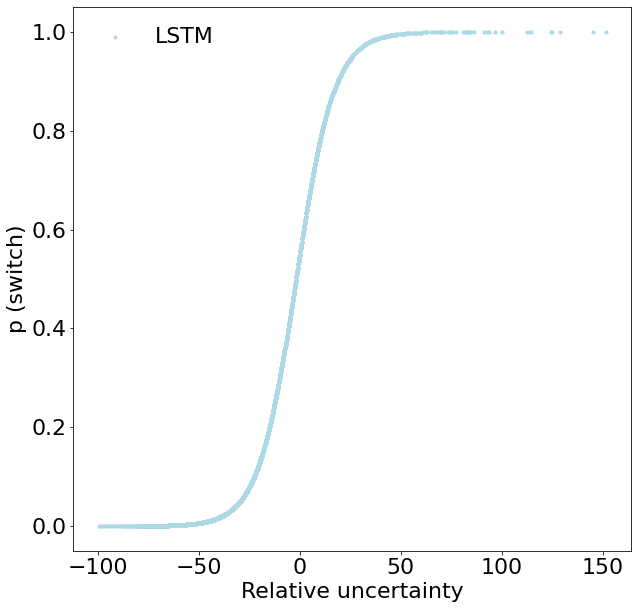

In [102]:
plt.scatter(lagged_unc_arr, y_lstm, color='lightblue', label = 'LSTM', marker='.')
#plt.plot(x_rel_rew, y_human, color='black', label = 'Human')
plt.ylabel('p (switch)')
plt.xlabel('Relative uncertainty')
plt.legend(frameon=False)

In [247]:
# create df
df = pd.DataFrame({'lagged_unc_ch': lagged_unc_arr, 'is_switch':switch_arr})

# create bins
df['rel_unc_bins'] = pd.qcut(df['lagged_unc_ch'], q=10000, duplicates = 'drop')

test_df = df.groupby(['rel_unc_bins']).mean()
test_df

,lagged_unc_ch,is_switch
rel_unc_bins,,
"(-99.501, -98.155]",-99.125,0.0
"(-98.155, -96.809]",-97.625,0.0
"(-96.809, -95.464]",-96.125,0.0
"(-95.464, -94.118]",-94.625,0.0
"(-94.118, -92.773]",-93.500,0.0
...,...,...
"(96.607, 110.305]",100.000,1.0
"(110.305, 114.155]",113.250,1.0
"(114.155, 124.706]",119.375,1.0


In [249]:
bin_x = np.zeros(np.shape(test_df)[0])

for i in range(np.shape(test_df)[0]):
    bin_x[i] = np.mean(np.array([test_df.index[i].left, test_df.index[i].right]))

In [250]:
test_df['mean_bin_vals'] = bin_x


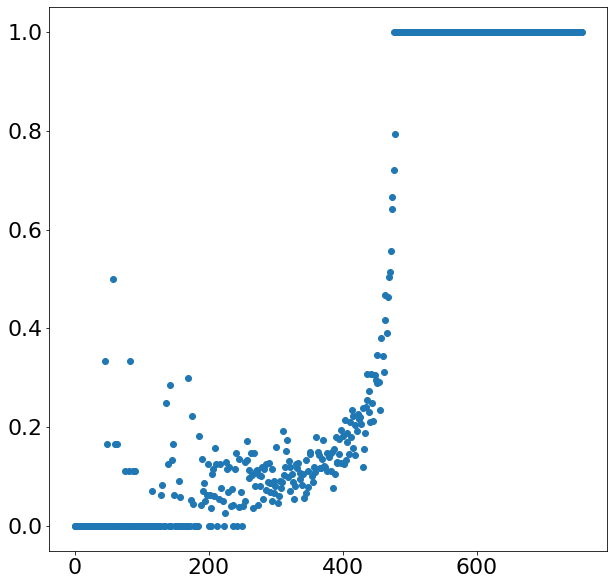

In [253]:
plt.scatter(range(np.shape(test_df)[0]), test_df.is_switch)

## Bandit Recency Plot

In [65]:
def get_unique_bandit_heuristic(my_choice, choice):
    
    n_trials = len(choice)
    other_choices = []
    unq_b_vec = np.zeros(n_trials)

    for t in range(n_trials):
        if choice[t] != -1: # if choice is valid
            if choice[t] != my_choice:

                other_choices.append(choice[t])
                unq_b_vec[t] = len(np.unique(other_choices))

            if choice[t] == my_choice:

                other_choices = []
                unq_b_vec[t] = 0
                
    return(unq_b_vec)

In [66]:
### lSTM

unq_bandit_counts_LSTM = np.zeros([1,3])

for id_ in range(20):
    for walk in range(1,4):


        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()

        choice = df_lstm['choice'].values

        # get unique_bandit_heuristic

        unq_bandit_1 = get_unique_bandit_heuristic(my_choice = 0, choice = choice)
        unq_bandit_2 = get_unique_bandit_heuristic(my_choice = 1, choice = choice)
        unq_bandit_3 = get_unique_bandit_heuristic(my_choice = 2, choice = choice)
        unq_bandit_4 = get_unique_bandit_heuristic(my_choice = 3, choice = choice)

        # shift 1 to get uncertainty value t-1 for witch choice at t
        shifted_unq_bandit_1 = pd.Series(unq_bandit_1).shift(1)
        shifted_unq_bandit_2 = pd.Series(unq_bandit_2).shift(1)
        shifted_unq_bandit_3 = pd.Series(unq_bandit_3).shift(1)
        shifted_unq_bandit_4 = pd.Series(unq_bandit_4).shift(1)

        # get chosen values

        lagged_ch_unc = [[u_1,u_2,u_3,u_4][ch] for ch, u_1,u_2,u_3,u_4 in zip(choice
                                                                              , shifted_unq_bandit_1 
                                                                              , shifted_unq_bandit_2 
                                                                              , shifted_unq_bandit_3 
                                                                              ,shifted_unq_bandit_4 )]


        # get uncertainty of switch trials
        switch_indices = np.where(df_lstm['is_switch'] == 1)    
        n_switches = np.shape(switch_indices)[1]
        ch_unc_at_switch = np.array(lagged_ch_unc)[switch_indices]

        # return counts
        _, counts = np.unique(ch_unc_at_switch, return_counts=True)

        # append to final array
        unq_bandit_counts_LSTM = np.vstack((unq_bandit_counts_LSTM, counts/n_switches)) # normalize counts




    

In [181]:
### Human

unq_bandit_counts_human = np.zeros([1,3])


path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

for sub in range(1, 32):
    
    df_lstm = human_df[human_df['vp'].values==sub]
    df_lstm['choice'] = df_lstm['choice'].values-1
    
    # use only valid choices
    choice = df_lstm['choice'].values
    is_valid = choice!=-1
    
    df_lstm = df_lstm[is_valid]
    choice = choice[is_valid]

    is_switch = [int(df_lstm['choice'].values[t] != df_lstm['choice'].values[t-1]) for t in range(1, len(df_lstm.choice))]
    is_switch = np.insert(is_switch, 0, 0) # insert leading 0, first element can't be switch
    df_lstm['is_switch'] = is_switch


    # get unique_bandit_heuristic

    unq_bandit_1 = get_unique_bandit_heuristic(my_choice = 0, choice = choice)
    unq_bandit_2 = get_unique_bandit_heuristic(my_choice = 1, choice = choice)
    unq_bandit_3 = get_unique_bandit_heuristic(my_choice = 2, choice = choice)
    unq_bandit_4 = get_unique_bandit_heuristic(my_choice = 3, choice = choice)

    # shift 1 to get uncertainty value t-1 for witch choice at t
    shifted_unq_bandit_1 = pd.Series(unq_bandit_1).shift(1)
    shifted_unq_bandit_2 = pd.Series(unq_bandit_2).shift(1)
    shifted_unq_bandit_3 = pd.Series(unq_bandit_3).shift(1)
    shifted_unq_bandit_4 = pd.Series(unq_bandit_4).shift(1)

    # get chosen values

    lagged_ch_unc = [[u_1,u_2,u_3,u_4][ch] for ch, u_1,u_2,u_3,u_4 in zip(choice
                                                                          , shifted_unq_bandit_1 
                                                                          , shifted_unq_bandit_2 
                                                                          , shifted_unq_bandit_3 
                                                                          ,shifted_unq_bandit_4 )]


    # get uncertainty of switch trials
    
    #valid_switches = df_lstm['is_switch'][is_valid]
    
    switch_indices = np.where(df_lstm['is_switch'] == 1)    
    n_switches = np.shape(switch_indices)[1]
    ch_unc_at_switch = np.array(lagged_ch_unc)[switch_indices]

    # return counts
    _, counts = np.unique(ch_unc_at_switch, return_counts=True)

    # append to final array
    unq_bandit_counts_human = np.vstack((unq_bandit_counts_human, counts/n_switches)) # normalize counts

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

([<matplotlib.axis.XTick at 0x21e85c73320>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

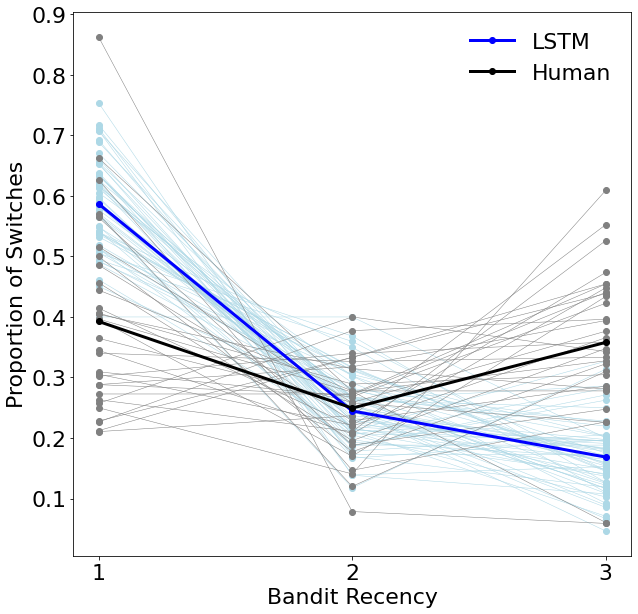

In [190]:
for i in range(1,np.shape(unq_bandit_counts_LSTM)[0]):
    plt.plot(range(1,4), unq_bandit_counts_LSTM[i,:], '-o', c = 'lightblue', linewidth=0.5)
    
for i in range(1,np.shape(unq_bandit_counts_human)[0]):
    plt.plot(range(1,4), unq_bandit_counts_human[i,:], '-o', c = 'grey', linewidth=0.5)

    
plt.plot(range(1,4), np.mean(unq_bandit_counts_LSTM[1:,:], axis = 0), '-o', c = 'blue',  linewidth=3.0, label = 'LSTM')
plt.plot(range(1,4), np.mean(unq_bandit_counts_human[1:,:], axis = 0), '-o', c = 'black', linewidth=3.0, label = 'Human')
plt.ylabel("Proportion of Switches")
plt.xlabel("Bandit Recency")
plt.legend(frameon = False)
plt.xticks([1,2,3])

In [82]:
np.mean(unq_bandit_counts_LSTM[1:,:], axis = 0)

array([0.58691835, 0.24465697, 0.16842468])

In [85]:
sem(unq_bandit_counts_LSTM[1:,:], axis = 0)

array([0.00944464, 0.0073476 , 0.00767356])

## Last Value Rank

In [21]:
def create_rank_vector(input):
    indices = list(range(len(input)))
    indices.sort(key=lambda x: input[x])
    output = [0] * len(indices)
    for i, x in enumerate(indices):
        output[x] = i
        
    return(output)


In [26]:
### LSTM

last_value_rank_counts_LSTM = np.zeros([1,3])

for id_ in range(20):
    for walk in range(1,4):

        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()
        choice = df_lstm['choice'].values
        n_trials = len(choice)
        is_switch=df_lstm['is_switch'].values
        n_switches = sum(is_switch)

        # get chosen reward # remove misses 
        reward = [[p1,p2,p3,p4][ch-1] if ch != -1 else 0 for ch, p1, p2, p3, p4 in zip(df_lstm['choice'], df_lstm['p_rew_1'], df_lstm['p_rew_2'], df_lstm['p_rew_3'], df_lstm['p_rew_4'])]

        # initialize 
        last_rewards = np.array([0.50,0.50,0.50,0.50])
        last_value_rank = np.array([np.nan] * n_trials)
        
        # get chosen value rank
        for t in range(n_trials):
            if choice[t] != -1: # choice == -1 is invalid

                if is_switch[t] == 1:

                    # delete reward of choice t-1
                    lr_w_ch = np.delete(last_rewards, choice[t-1])
                    # create temporary df to index last reward 
                    df=pd.DataFrame({'last_rewards_except_prev_ch':  lr_w_ch, 'rank':  create_rank_vector(lr_w_ch)})
                    # get rank of last reward of chosen option
                    last_value_rank[t] = df['rank'][df['last_rewards_except_prev_ch']==last_rewards[choice[t]]].values[0]
                    # update observed rewards
                    last_rewards[choice[t]] = reward[t]
                    
                else:
                    # update observed rewards
                    last_rewards[choice[t]] = reward[t]

        # get counts
        _ , counts = np.unique(last_value_rank[~np.isnan(last_value_rank)], return_counts=True)

        # append normalized counts
        last_value_rank_counts_LSTM = np.vstack((last_value_rank_counts_LSTM, counts/n_switches))

In [39]:
### Human

last_value_rank_counts_human = np.zeros([1,3])

path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

for sub in range(1, 32):
    
    df_lstm = human_df[human_df['vp'].values==sub]
    df_lstm['choice'] = df_lstm['choice'].values-1
    
    # use only valid choices
    choice = df_lstm['choice'].values
    is_valid = choice!=-1
    
    df_lstm = df_lstm[is_valid]
    choice = choice[is_valid]
    
    n_trials = len(choice)
    is_switch = [int(df_lstm['choice'].values[t] != df_lstm['choice'].values[t-1]) for t in range(1, len(df_lstm.choice))]
    is_switch = np.insert(is_switch, 0, 0) # insert leading 0, first element can't be switch
    n_switches = sum(is_switch)

    # get chosen reward # remove misses 
    reward = [[p1,p2,p3,p4][ch-1] if ch != -1 else 0 for ch, p1, p2, p3, p4 in zip(df_lstm['choice'], df_lstm['reward_b1'], df_lstm['reward_b2'], df_lstm['reward_b3'], df_lstm['reward_b4'])]

    # initialize 
    last_rewards = np.array([50,50,50,50])
    last_value_rank = np.array([np.nan] * n_trials)
        
    # get chosen value rank
    for t in range(n_trials):
        if choice[t] != -1:

            if is_switch[t] == 1:

                # delete reward of choice t-1
                lr_w_ch = np.delete(last_rewards, choice[t-1])
                # create temporary df to index last reward 
                df=pd.DataFrame({'last_rewards_except_prev_ch':  lr_w_ch, 'rank':  create_rank_vector(lr_w_ch)})
                # get rank of last reward of chosen option
                last_value_rank[t] = df['rank'][df['last_rewards_except_prev_ch']==last_rewards[choice[t]]].values[0]
                # update observed rewards
                last_rewards[choice[t]] = reward[t]

            else:
                # update observed rewards
                last_rewards[choice[t]] = reward[t]

    # get counts
    _ , counts = np.unique(last_value_rank[~np.isnan(last_value_rank)], return_counts=True)

    # append normalized counts
    last_value_rank_counts_human = np.vstack((last_value_rank_counts_human, counts/n_switches))

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

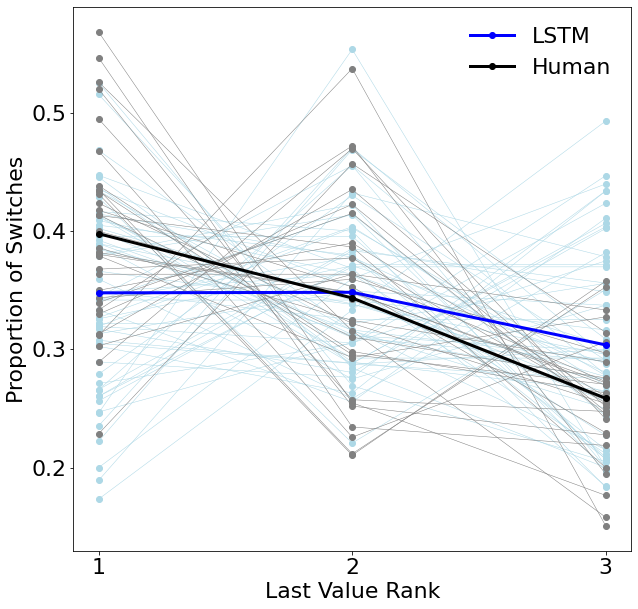

In [41]:
for i in range(1,np.shape(last_value_rank_counts_LSTM)[0]):
    plt.plot(range(1,4), last_value_rank_counts_LSTM[i,:], '-o', c = 'lightblue', linewidth=0.5)
    
for i in range(1,np.shape(last_value_rank_counts_human)[0]):
    plt.plot(range(1,4), last_value_rank_counts_human[i,:], '-o', c = 'grey', linewidth=0.5)


    
plt.plot(range(1,4), np.mean(last_value_rank_counts_LSTM[1:,:], axis = 0), '-o', c = 'blue',  linewidth=3.0, label = 'LSTM')
plt.plot(range(1,4), np.mean(last_value_rank_counts_human[1:,:], axis = 0), '-o', c = 'black', linewidth=3.0, label = 'Human')
plt.ylabel("Proportion of Switches")
plt.xlabel("Last Value Rank")
plt.legend(frameon = False)
plt.xticks([1,2,3])

plt.savefig('last_value_rank_plot.png')

# Switches by objective value

In [84]:
### LSTM

obj_value_rank_counts_LSTM = np.zeros([1,3])

for id_ in range(20):
    for walk in range(1,4):

        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()
        choice = df_lstm['choice'].values
        n_trials = len(choice)
        is_switch=df_lstm['is_switch'].values
        n_switches = sum(is_switch)
        
        # initialize 
        obj_value_rank = np.array([np.nan] * n_trials)
        
        # get chosen value rank
        for t in range(n_trials):
            if choice[t] != -1: # choice == -1 is invalid

                if is_switch[t] == 1:
                    
                    # get rewards of all options expect choice t-1
                    all_rewards = df_lstm[['p_rew_1', 'p_rew_2', 'p_rew_3', 'p_rew_4']].values[t]
                    remaining_rewards = np.delete(all_rewards, choice[t-1])
                    # get rank of switch target
                    df=pd.DataFrame({'last_rewards_except_prev_ch':  remaining_rewards, 'rank': create_rank_vector(remaining_rewards)})
                    # append
                    obj_value_rank[t] = df['rank'][df['last_rewards_except_prev_ch']==all_rewards[choice[t]]].values[0]

        # get counts
        _ , counts = np.unique(obj_value_rank[~np.isnan(obj_value_rank)], return_counts=True)

        # append normalized counts
        obj_value_rank_counts_LSTM = np.vstack((obj_value_rank_counts_LSTM, counts/n_switches))

In [85]:
### Human

obj_value_rank_counts_human = np.zeros([1,3])

path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

for sub in range(1, 32):
    
    df_lstm = human_df[human_df['vp'].values==sub]
    df_lstm['choice'] = df_lstm['choice'].values-1
    
    # use only valid choices
    choice = df_lstm['choice'].values
    is_valid = choice!=-1
    
    df_lstm = df_lstm[is_valid]
    choice = choice[is_valid]
    
    n_trials = len(choice)
    is_switch = [int(df_lstm['choice'].values[t] != df_lstm['choice'].values[t-1]) for t in range(1, len(df_lstm.choice))]
    is_switch = np.insert(is_switch, 0, 0) # insert leading 0, first element can't be switch
    n_switches = sum(is_switch)

    # initialize 
    obj_value_rank = np.array([np.nan] * n_trials)
        
    # get chosen value rank
    for t in range(n_trials):
        if choice[t] != -1:

            if is_switch[t] == 1:

                # get rewards of all options expect choice t-1
                all_rewards = df_lstm[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].values[t]
                remaining_rewards = np.delete(all_rewards, choice[t-1])
                # get rank of switch target
                df=pd.DataFrame({'last_rewards_except_prev_ch':  remaining_rewards, 'rank': create_rank_vector(remaining_rewards)})
                # append
                obj_value_rank[t] = df['rank'][df['last_rewards_except_prev_ch']==all_rewards[choice[t]]].values[0]

    # get counts
    _ , counts = np.unique(obj_value_rank[~np.isnan(obj_value_rank)], return_counts=True)

    # append normalized counts
    obj_value_rank_counts_human = np.vstack((obj_value_rank_counts_human, counts/n_switches))

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

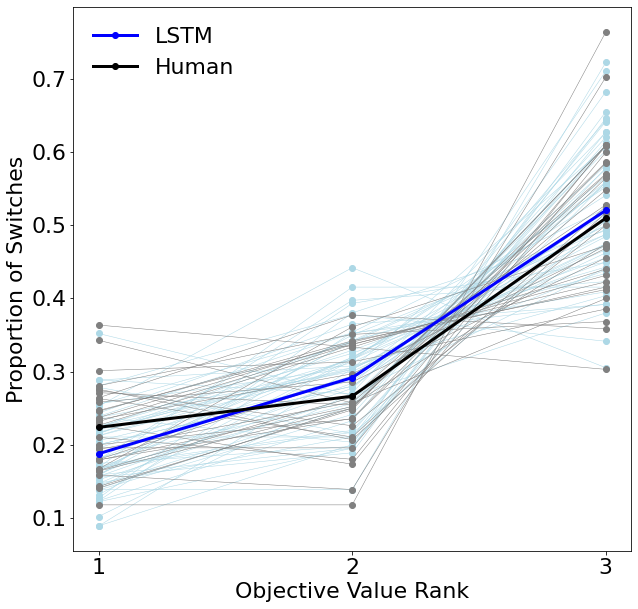

In [86]:
### Plotting

for i in range(1,np.shape(obj_value_rank_counts_LSTM)[0]):
    plt.plot(range(1,4), obj_value_rank_counts_LSTM[i,:], '-o', c = 'lightblue', linewidth=0.5)
    
for i in range(1,np.shape(obj_value_rank_counts_human)[0]):
    plt.plot(range(1,4), obj_value_rank_counts_human[i,:], '-o', c = 'grey', linewidth=0.5)

plt.plot(range(1,4), np.mean(obj_value_rank_counts_LSTM[1:,:], axis = 0), '-o', c = 'blue',  linewidth=3.0, label = 'LSTM')
plt.plot(range(1,4), np.mean(obj_value_rank_counts_human[1:,:], axis = 0), '-o', c = 'black',  linewidth=3.0, label = 'Human')

plt.ylabel("Proportion of Switches")
plt.xlabel("Objective Value Rank")
plt.legend(frameon = False)
plt.xticks([1,2,3])

plt.savefig('obj_value_rank_plot.png')

# Histogram reward switch target - mean reward other

In [119]:
### LSTM

diff_switch_target_mean_other_LSTM = []

for id_ in range(20):
    for walk in range(1,4):

        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()
        choice = df_lstm['choice'].values
        n_trials = len(choice)
        is_switch=df_lstm['is_switch'].values
        n_switches = sum(is_switch)
        
        # initialize 
        obj_value_rank = np.array([np.nan] * n_trials)
        
        # get difference reward switch target - mean other
        for t in range(n_trials):
            if choice[t] != -1: # choice == -1 is invalid

                if is_switch[t] == 1:
                    
                    # get rewards of all options expect choice t-1
                    all_rewards = df_lstm[['p_rew_1', 'p_rew_2', 'p_rew_3', 'p_rew_4']].values[t]
                    # get reward of switch target
                    reward_switch_target = all_rewards[choice[t]]
                    # get reward of mean other except choice t-1 and choice t
                    mean_other = np.mean(np.delete(all_rewards, [choice[t], choice[t-1]]))
                    # append difference
                    diff_switch_target_mean_other_LSTM.append(reward_switch_target - mean_other)
                    
# rescale rewards for comparison
diff_switch_target_mean_other_LSTM = np.multiply(diff_switch_target_mean_other_LSTM, 100)

                    

In [120]:
### Human

diff_switch_target_mean_other_human = []


path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

for sub in range(1, 32):
    
    df_lstm = human_df[human_df['vp'].values==sub]
    df_lstm['choice'] = df_lstm['choice'].values-1
    
    # use only valid choices
    choice = df_lstm['choice'].values
    is_valid = choice!=-1
    
    df_lstm = df_lstm[is_valid]
    choice = choice[is_valid]
    
    n_trials = len(choice)
    is_switch = [int(df_lstm['choice'].values[t] != df_lstm['choice'].values[t-1]) for t in range(1, len(df_lstm.choice))]
    is_switch = np.insert(is_switch, 0, 0) # insert leading 0, first element can't be switch
    n_switches = sum(is_switch)

    # initialize 
    obj_value_rank = np.array([np.nan] * n_trials)
        
    # get chosen value rank
    for t in range(n_trials):
        if choice[t] != -1:

            if is_switch[t] == 1:

                # get rewards of all options expect choice t-1
                all_rewards = df_lstm[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].values[t]
                # get reward of switch target
                reward_switch_target = all_rewards[choice[t]]
                # get reward of mean other except choice t-1 and choice t
                mean_other = np.mean(np.delete(all_rewards, [choice[t], choice[t-1]]))
                # append difference
                diff_switch_target_mean_other_human.append(reward_switch_target - mean_other)

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Text(0.5, 0, 'switch target - mean(other)')

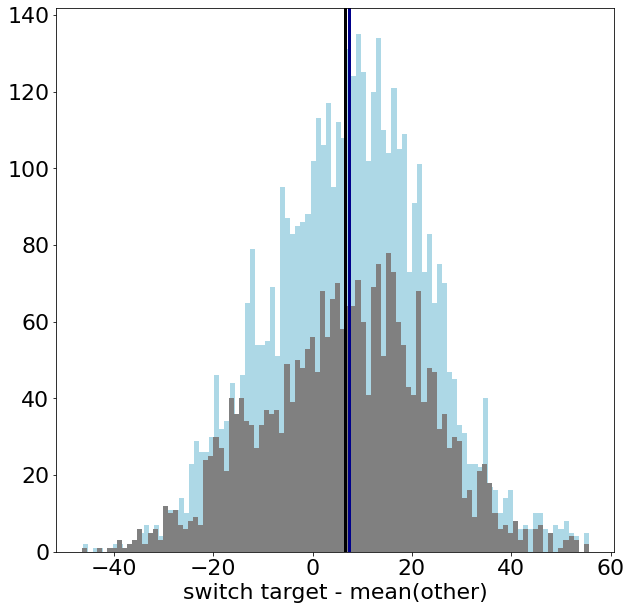

In [125]:
### Plotting


plt.hist(diff_switch_target_mean_other_LSTM, bins=100, color = 'lightblue', alpha = 1)
plt.axvline(np.mean(diff_switch_target_mean_other_LSTM), c = 'darkblue', linewidth = 3)

plt.hist(diff_switch_target_mean_other_human, bins=100, color = 'grey', alpha = 1)
plt.axvline(np.mean(diff_switch_target_mean_other_human), c = 'black', linewidth = 3)

plt.ylabel("")
plt.xlabel("switch target - mean(other)")

#plt.savefig('switch_target_mean_other_hist.png')



In [116]:
np.multiply(diff_switch_target_mean_other_LSTM, 100)


array([  9.49187183, -26.44466612,  33.28181769, ...,   6.29434984,
       -20.11157879,  10.21325979])

In [111]:
mean_other

63.2705951675304